In [112]:
import os
import sys
import numpy as np
import cv2
import shutil
from tqdm import tqdm
import pandas as pd
import time

from IPython.display import Image, display as idisplay
import PIL
from PIL import Image


def longest_resize(img, resize = 416):
    h, w = img.shape[:2]
    r = resize / max(h, w)
    new_h, new_w = int(r * h), int(r * w)
    img = cv2.resize(img, (new_w, new_h))
    return img

def display(img, resize = None):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = longest_resize(img, resize)
    idisplay(Image.fromarray(img))
    print('\n--------------------------\n')

In [21]:
LABEL_DIR = '../src/roi_det/YOLOX/runs/detect/yolox_nano_bre_416/coco_txt_with_conf/'
SAVE_LABEL_DIR = '../datasets/roi_det/detect/yolox_nano_bre_416_datav2'
MISSING_LABEL_DIR = '../src/roi_det/YOLOX/runs/detect/yolox_nano_bre_416/miss/'
IMG_DIR = '../datasets/export/uint8_voilut_png/'

In [3]:
os.makedirs(SAVE_LABEL_DIR, exist_ok = True)

In [4]:
names = os.listdir(LABEL_DIR)
xywhs = []
img_whs = []


for label_name in tqdm(names):
    label_path = os.path.join(LABEL_DIR, label_name)
    # cls, x, y, w, h, box_conf, cls_conf, h, w
    label = np.loadtxt(label_path, delimiter=' ').reshape((-1, 9))
    confs = label[:,5] * label[:,6]
    idx = np.argmax(confs)
    select = label[idx]
    save_path = os.path.join(SAVE_LABEL_DIR, label_name)
    np.savetxt(save_path, select[:5].reshape((1, 5)), delimiter = ' ')
    xywhs.append(select[1:5])
    img_whs.append(select[7:])
    
xywhs = np.array(xywhs)
img_whs = np.array(img_whs)
print(xywhs.shape, img_whs.shape)
    
    

100%|█████████████████████████████████████████████| 54703/54703 [02:22<00:00, 384.52it/s]


(54703, 4) (54703, 2)


In [6]:
img_whs = img_whs[:, [1, 0]]

In [7]:
pixel_box_whs = xywhs[:, 2:] * img_whs

Relative ROI box width


count    54703.000000
mean         0.553564
std          0.144259
min          0.120775
25%          0.455283
50%          0.544963
75%          0.643356
max          1.023590
dtype: float64

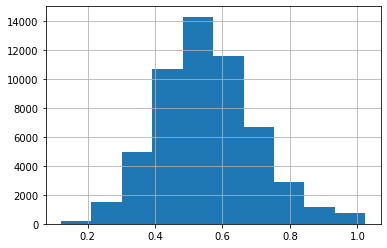

In [13]:
print('Relative ROI box width')
s = pd.Series(xywhs[:, 2])
s.hist()
s.describe()

Relative ROI box height


count    54703.000000
mean         0.782362
std          0.086573
min          0.360079
25%          0.721841
50%          0.783034
75%          0.844060
max          1.030450
dtype: float64

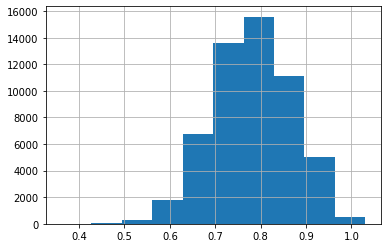

In [14]:
print('Relative ROI box height')
s = pd.Series(xywhs[:, 3])
s.hist()
s.describe()

Absolute (pixel) ROI box width


count    54703.000000
mean      1735.734060
std        611.352531
min        244.727868
25%       1273.907076
50%       1665.084928
75%       2123.905904
max       4797.723185
dtype: float64

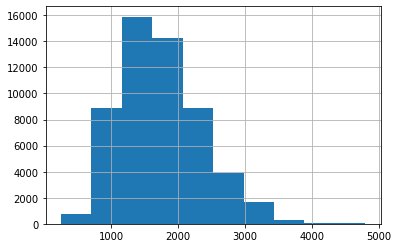

In [16]:
print('Absolute (pixel) ROI box width')
s = pd.Series(pixel_box_whs[:, 0])
s.hist()
s.describe()

Absolute (pixel) ROI box height


count    54703.000000
mean      3009.933496
std        703.881515
min        727.601064
25%       2484.464480
50%       2961.876736
75%       3431.461252
max       5603.003328
dtype: float64

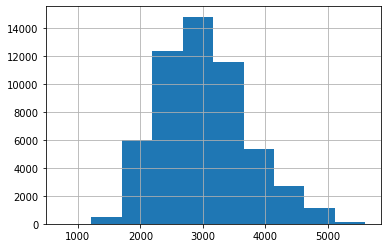

In [17]:
print('Absolute (pixel) ROI box height')
s = pd.Series(pixel_box_whs[:, 1])
s.hist()
s.describe()

1.85 +- 0.45

Absolute (pixel) ROI box ratio


count    54703.000000
mean         1.847288
std          0.449351
min          0.802860
25%          1.531076
50%          1.787551
75%          2.089795
max          6.353953
dtype: float64

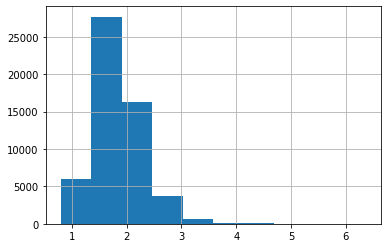

In [188]:
print('Absolute (pixel) ROI box ratio')
s = pd.Series(pixel_box_whs[:, 1] / pixel_box_whs[:, 0])
s.hist()
s.describe()

Image (dicom) width


count    54703.000000
mean      3173.102060
std        905.421772
min       1022.000000
25%       2560.000000
50%       3328.000000
75%       3328.000000
max       4915.000000
dtype: float64

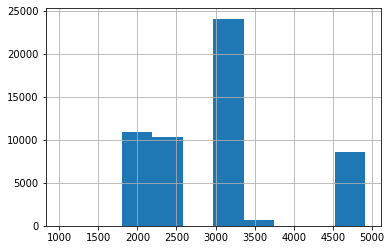

In [18]:
print('Image (dicom) width')
s = pd.Series(img_whs[:, 0])
s.hist()
s.describe()

Image (dicom) height


count    54703.000000
mean      3867.236459
std        871.233469
min       1236.000000
25%       3328.000000
50%       4096.000000
75%       4096.000000
max       5928.000000
dtype: float64

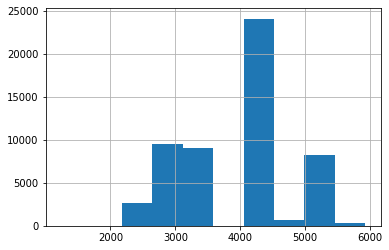

In [19]:
print('Image (dicom) height')
s = pd.Series(img_whs[:, 1])
s.hist()
s.describe()

Image (dicom) height


count    54703.000000
mean         0.439373
std          0.143504
min          0.053558
25%          0.339337
50%          0.426318
75%          0.526327
max          1.026594
dtype: float64

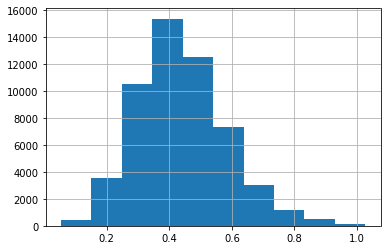

In [173]:
print('Image (dicom) height')
s = pd.Series(xywhs[:, 2] * xywhs[:, 3])
s.hist()
s.describe()


##  OTSU

In [181]:
def extract_roi_otsu(img, gkernel = (5, 5), debug = False):
    # clip percentile: implant, white lines
    upper = np.percentile(img, 95)
    img[img > upper] = np.min(img)
    # Gaussian filtering to reduce noise (optional)
    if gkernel is not None:
        img = cv2.GaussianBlur(img, gkernel, 0)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # dilation to improve contours connectivity
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3), (-1, -1))
    img_bin = cv2.dilate(img_bin, element)
    if debug:
        _temp = np.expand_dims(img_bin, -1)
        display(_temp, 640)
    
    cnts, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return [None, None, None, None], None, None
    areas = np.array([cv2.contourArea(cnt) for cnt in cnts])
    select_idx = np.argmax(areas)
    cnt = cnts[select_idx]
    area_pct = areas[select_idx] / (img.shape[0] * img.shape[1])
    l, t, w, h = cv2.boundingRect(cnt)
    return [l, t, w, h], area_pct, cnts

2.7 +- 0.3 ms

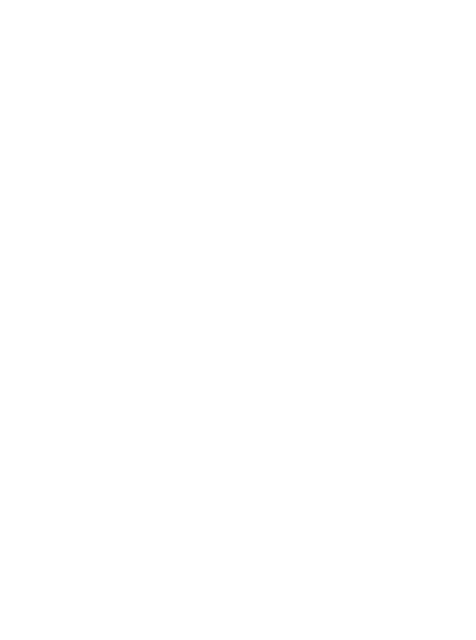


--------------------------

RET: 0 0 310 416 0.9943781017369727
822@1942326353.png


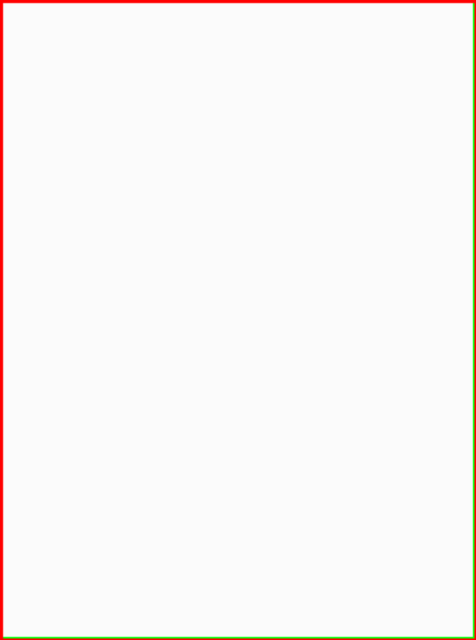


--------------------------



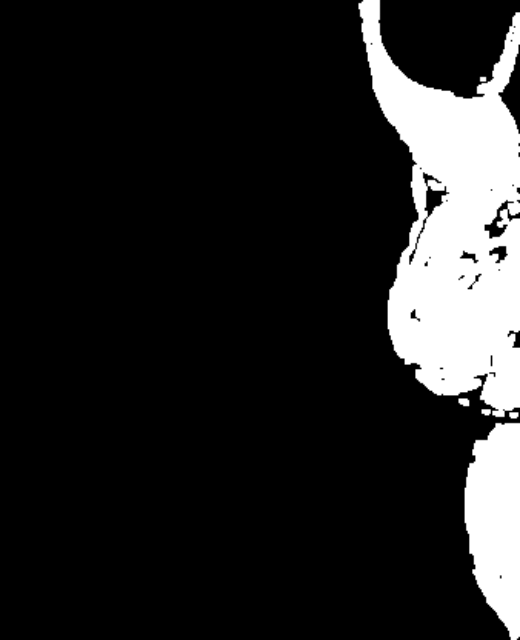


--------------------------

RET: 233 0 105 271 0.11406178880291307
2738@1154819623.png


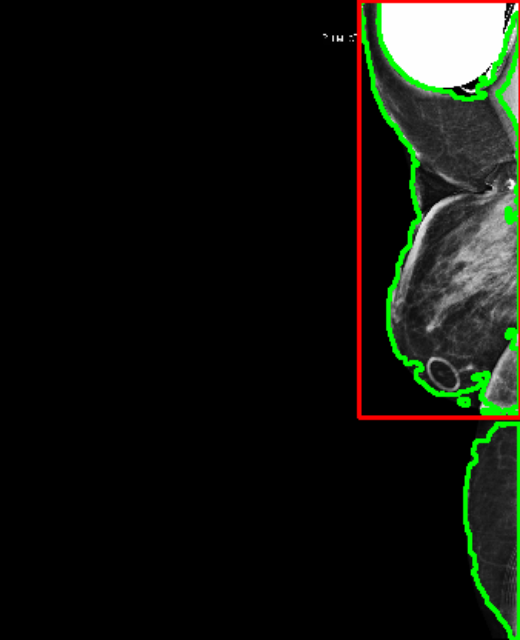


--------------------------



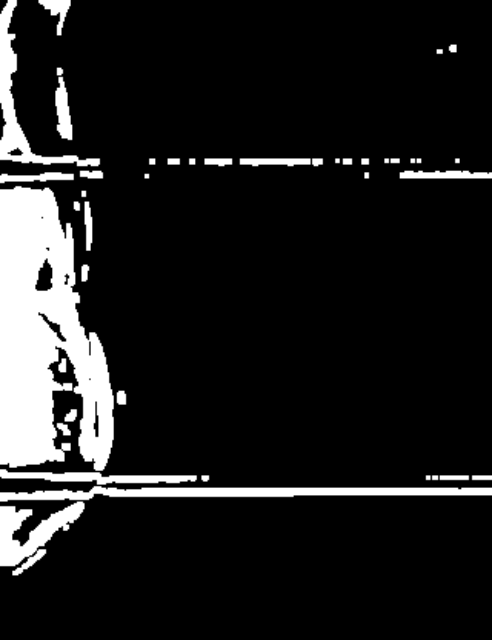


--------------------------

RET: 0 121 74 185 0.06764197716346154
38739@1189630231.png


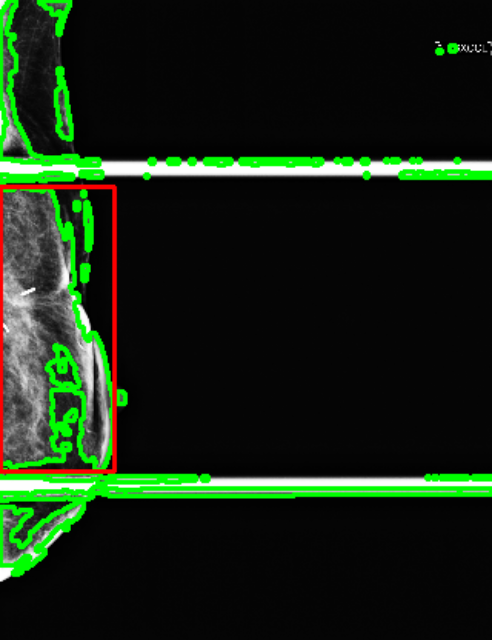


--------------------------

0.011924107869466146 0.002761225964629176


In [179]:
misses = os.listdir(MISSING_LABEL_DIR)
# misses = os.listdir(LABEL_DIR)[:100]
IMG_DIR = '../datasets/export/uint8_voilut_png/'

takes = []
for miss in misses:
    img_name = miss.replace('.txt', '.png')
    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    img = longest_resize(img, 416)
    start = time.time()
    (l, t, w, h), area_pct, cnts = extract_roi_otsu(img[..., -1].copy(), debug = True)
    if cnts is None:
        continue
    end = time.time()
    take = end - start
    takes.append(take)
    print('RET:', l, t, w, h, area_pct)
    
    img = cv2.drawContours(img, cnts, -1, (0, 255, 0), 2)
    img = cv2.rectangle(img, (l, t), (l + w, t + h), (255, 0, 0), 2)
    print(miss)
    display(img, resize = 640)
    
takes = np.array(takes)
print(takes.mean(), takes.std())
    

# CCA

In [169]:
def extract_roi_cca(img, thres = 20):
    # BINARIZE --> CCA
    # Some images have narrow exterior "frames" that complicate selection of the main data. Cutting off the frame
#     img = img[5:-5, 5:-5]
    
#     img_bin = (img > thres).astype(np.uint8)

    img = img.copy()
    upper = np.percentile(img, 95)
    img[img > upper] = np.min(img)
    # Gaussian filtering to reduce noise (optional)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # dilation to improve contours connectivity
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3), (-1, -1))
    img_bin = cv2.dilate(img_bin, element)
    
    
    output= cv2.connectedComponentsWithStats(img_bin, 8, cv2.CV_32S)

    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
    stats = output[2]

    # finding max area which always corresponds to the breast data. 
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    return [x1, y1, w, h], None

1.424 +- 0.175 ms


0.0034605026245117187 0.00041282919070992466

Take: 0.003851652145385742
RET: 0 0 310 416
822@1942326353.png


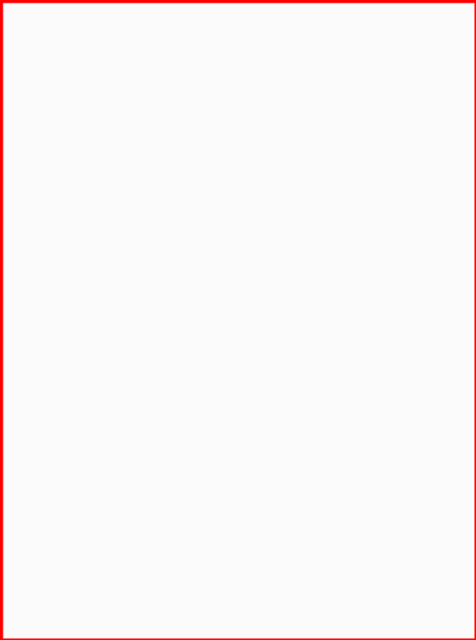


--------------------------

Take: 0.0037240982055664062
RET: 233 0 105 271
2738@1154819623.png


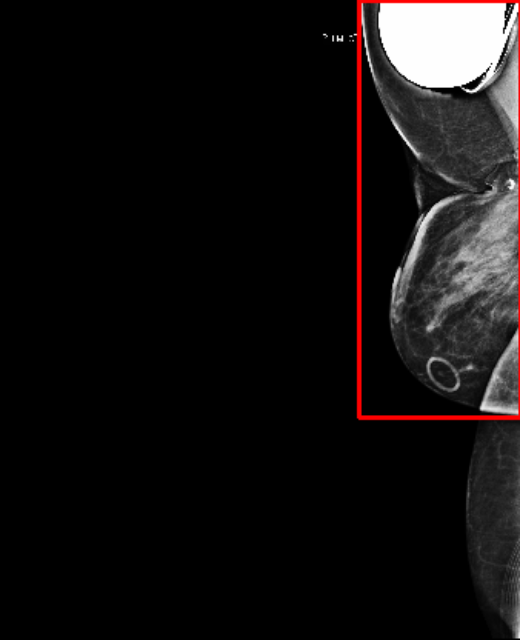


--------------------------

Take: 0.0038886070251464844
RET: 0 121 74 185
38739@1189630231.png


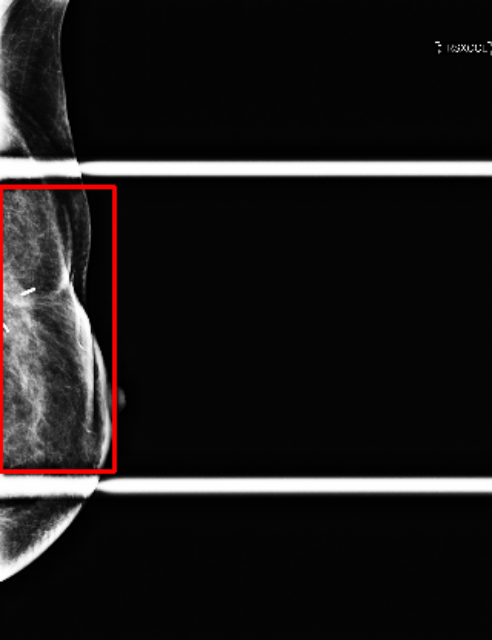


--------------------------

0.0038214524586995444 7.047365340733639e-05


In [172]:
misses = os.listdir(MISSING_LABEL_DIR)
# misses = os.listdir(LABEL_DIR)[:100]
IMG_DIR = '../datasets/export/uint8_voilut_png/'

takes = []
for miss in misses:
    img_name = miss.replace('.txt', '.png')
    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    img = longest_resize(img, 416)
    start = time.time()
    (l, t, w, h), _ = extract_roi_cca(img[..., -1])
    end = time.time()
    take = end - start
    takes.append(take)
    print('Take:', take)
    print('RET:', l, t, w, h)
    img = cv2.rectangle(img, (l, t), (l + w, t + h), (255, 0, 0), 2)
    print(miss)
    display(img, resize = 640)
    
takes = np.array(takes)
print(takes.mean(), takes.std())
    

## Handle missing

RET: 0 0 310 416 0.9943781017369727
822@1942326353.png


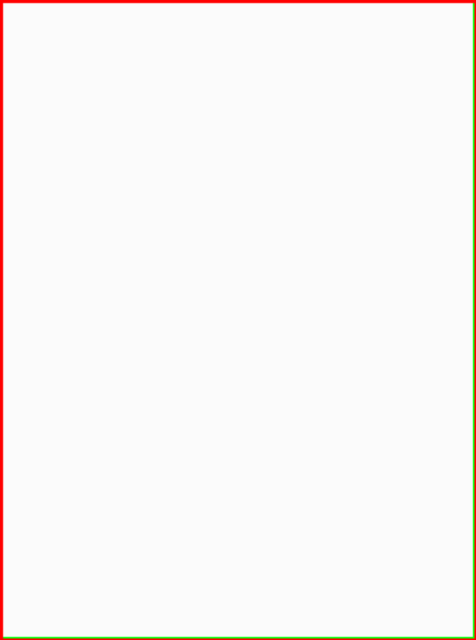


--------------------------

RET: 233 0 105 271 0.11406178880291307
2738@1154819623.png


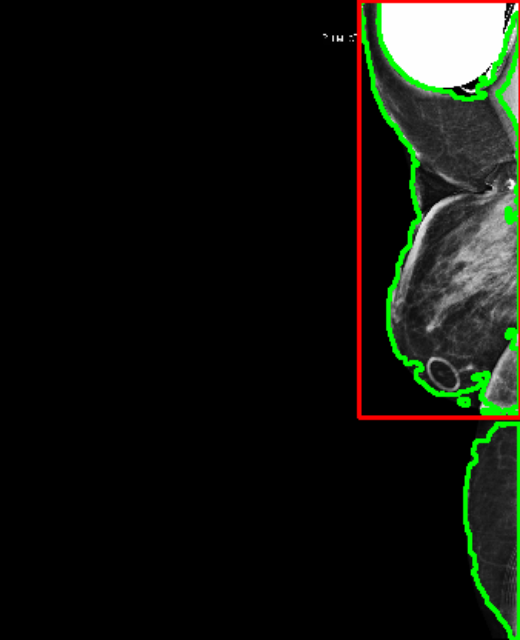


--------------------------

RET: 0 121 74 185 0.06764197716346154
38739@1189630231.png


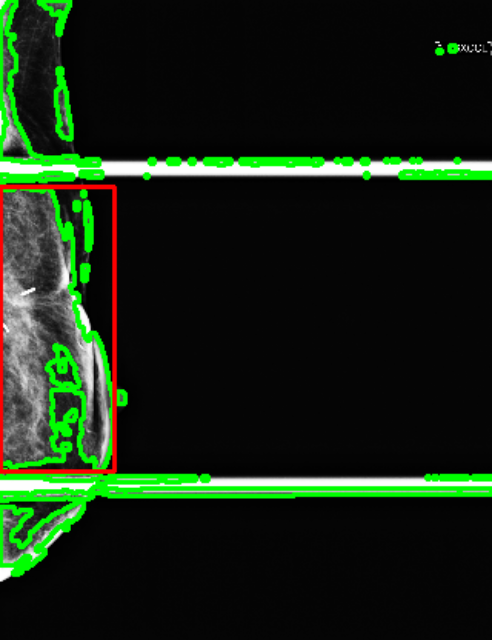


--------------------------

0.0035041173299153647 0.0001612861696163991


In [187]:
misses = os.listdir(MISSING_LABEL_DIR)
IMG_DIR = '../datasets/export/uint8_voilut_png/'

takes = []
for miss in misses:
    img_name = miss.replace('.txt', '.png')
    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    img = longest_resize(img, 416)
    img_h, img_w = img.shape[:2]
    start = time.time()
    (l, t, w, h), area_pct, cnts = extract_roi_otsu(img[..., -1].copy(), debug = False)
    save_path = os.path.join(SAVE_LABEL_DIR, miss.replace('.png', '.txt'))
    xywh = [(l + w/2)/img_w, (t + h/2) / img_h, w / img_w, h / img_h]
    save_arr = np.array([0, *xywh]).reshape((1, 5))
    np.savetxt(save_path, save_arr, delimiter=' ')
    if cnts is None or area_pct < 0.04:
        print('WARNING:', miss)
        raise AssertionError()
    end = time.time()
    take = end - start
    takes.append(take)
    print('RET:', l, t, w, h, area_pct)
    
    img = cv2.drawContours(img, cnts, -1, (0, 255, 0), 2)
    img = cv2.rectangle(img, (l, t), (l + w, t + h), (255, 0, 0), 2)
    print(miss)
    display(img, resize = 640)
    
takes = np.array(takes)
print(takes.mean(), takes.std())